# Bent waveguides (layout and simulation)

Step by step process:
1. Draw a bent waveguide and save it in a .gds file.
2. Load the bent waveguide using Meep.
3. Setup simulation environment.
4. Simulate FDTD and visualize results.
5. Compute loss and reflection of the bend.

In [40]:
import pya
import numpy as np

SIM_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE1 = pya.LayerInfo(10, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)

## Simulation Parameters

In [91]:
ring_radius = 5 # um
ring_width = 0.5 # um
straight_wg_length = 2.0 # um

## Step 1. Drawing a bent waveguide and saving into a temporary .gds file

In [92]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box
from tempfile import NamedTemporaryFile

# Create a temporary filename
temp_file = NamedTemporaryFile(delete=False, suffix='.gds')
filename = temp_file.name

# Clean existing file
!rm {filename}

# Instantiate a layout and a top cell
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

# Unit vectors
ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# Draw simulation region
layout_box(TOP, SIM_CELL, 
           -1.0*ring_radius*ey - straight_wg_length * (ex + ey), # Bottom left point 
            1.0*ring_radius*ex + straight_wg_length * (ex + ey),  # Top right point
           ex)  # Cartesian unit vector

# Draw circular bend
layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)

# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [0*ex, - straight_wg_length*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, 
                           -straight_wg_length * ey - ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width * 4.0

# Source port
layout_path(TOP, MEEP_SOURCE1, [-port_size/2*ey - 0.4*ex, port_size/2*ey - 0.4*ex], 0)
# Input port (next to source)
layout_path(TOP, MEEP_PORT1, [-port_size/2*ey - 0.2*ex, port_size/2*ey - 0.2*ex], 0)
# Output port
layout_path(TOP, MEEP_PORT2, [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex, 
                              -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)

# Write to file
layout.write(filename)
print(f"Produced file {filename}.")
!ls -lh {filename}

Produced file /tmp/tmpv0nnz_2p.gds.
-rw-r--r-- 1 tlima grad 1.5K Feb 22 23:50 /tmp/tmpv0nnz_2p.gds


## Step 2. Load gds file into meep

### Visualization and simulation

If you choose a normal filename (not temporary), you can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating:

In [93]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Simulation resolution
res = 128        # pixels/μm

gdsII_file = filename
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

dpml = 1
cell_thickness = dpml+t_oxide+t_Si+t_SiO2+dpml
si_zmin = 0

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
# WARNING: Once the file is loaded, the prism contents is cached and cannot be reloaded.
# SOLUTION: Use a different filename or restart the kernel

si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.EVEN_Y,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=si_layer,
                    geometry_center=cell.center)

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))

# Delete file created in previous cell

import os 
temp_file.close()
os.unlink(filename)

## Step 3. Setup simulation environment

This will load the python-defined parameters from the previous cell and instantiate a fast, C++ based, simulation environment using meep. It will also compute the eigenmode of the source, in preparation for the FDTD simulation.

In [94]:
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000649929 s
Working in 2D dimensions.
Computational cell is 9 x 9 x 0 with resolution 128
     prism, center = (3.17245,-1.82755,0)
          height 0, axis (0,0,1), 130 vertices:
          (4.75,-5,0)
          (4.749,-4.883,0)
          (4.744,-4.767,0)
          (4.737,-4.651,0)
          (4.727,-4.534,0)
          (4.714,-4.419,0)
          (4.699,-4.303,0)
          (4.68,-4.188,0)
          (4.659,-4.073,0)
          (4.635,-3.959,0)
          (4.608,-3.846,0)
          (4.578,-3.733,0)
          (4.545,-3.621,0)
          (4.51,-3.51,0)
          (4.472,-3.4,0)
          (4.432,-3.29,0)
          (4.388,-3.182,0)
          (4.342,-3.075,0)
          (4.294,-2.969,0)
          (4.243,-2.864,0)
          (4.189,-2.761,0)
          (4.133,-2.659,0)
          (4.074,-2.558,0)
          (4.013,-2.459,0)
          (3.949,-2.361,0)
          (3.884,-2.265,0)
          (3.815,-2.17,0)
          (3.745,-2.078,0)
    

### Verify that the structure makes sense.

Things to check:
- Are the sources and ports outside the PML?
- Are dimensions correct?
- Is the simulation region unnecessarily large?

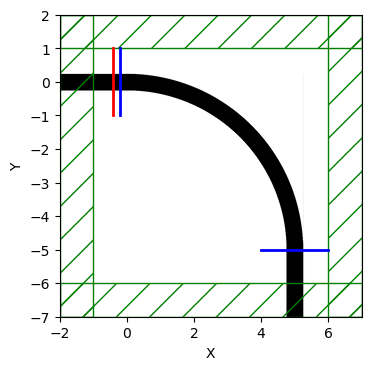

In [95]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Looks pretty good. Simulations at the high enough resolution required to avoid spurious reflections in the bend are very slow! This can be sped up quite a bit by running the code in parallel from the terminal. Later, we will put this notebook's code into a script and run it in parallel.

## Step 4. Simulate FDTD and Animate results

In [96]:
# Set to true to compute animation (may take a lot of memory)
compute_animation = True

In [97]:
# Setup and run the simulation
if compute_animation:
    f = plt.figure(dpi=100)
    animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
    sim.run(mp.at_every(1,animate), until_after_sources=30)
    plt.close()
else:
    sim.run(until_after_sources=30)

Meep progress: 0.61328125/107.5 = 0.6% done in 4.0s, 699.9s to go
on time step 157 (time=0.613281), 0.0255806 s/step
Meep progress: 1.0/107.5 = 0.9% done in 11.3s, 1206.0s to go
on time step 256 (time=1), 0.0738135 s/step
Meep progress: 1.66796875/107.5 = 1.6% done in 15.3s, 972.9s to go
on time step 427 (time=1.66797), 0.0234431 s/step
Meep progress: 2.27734375/107.5 = 2.1% done in 19.3s, 893.6s to go
on time step 583 (time=2.27734), 0.0256771 s/step
Meep progress: 2.87109375/107.5 = 2.7% done in 23.4s, 851.1s to go
on time step 735 (time=2.87109), 0.0264024 s/step
Meep progress: 3.4453125/107.5 = 3.2% done in 27.4s, 826.2s to go
on time step 882 (time=3.44531), 0.0272266 s/step
Meep progress: 4.0/107.5 = 3.7% done in 31.4s, 813.3s to go
on time step 1024 (time=4), 0.028701 s/step
Meep progress: 4.515625/107.5 = 4.2% done in 35.5s, 808.6s to go
on time step 1156 (time=4.51562), 0.0304674 s/step
Meep progress: 5.01171875/107.5 = 4.7% done in 39.5s, 807.4s to go
on time step 1283 (time=

Meep progress: 45.64453125/107.5 = 42.5% done in 288.2s, 390.5s to go
on time step 11686 (time=45.6484), 0.023364 s/step
Meep progress: 46.31640625/107.5 = 43.1% done in 292.2s, 386.0s to go
on time step 11858 (time=46.3203), 0.0232566 s/step
Meep progress: 47.0/107.5 = 43.7% done in 296.2s, 381.3s to go
on time step 12032 (time=47), 0.0232627 s/step
Meep progress: 47.68359375/107.5 = 44.4% done in 300.3s, 376.7s to go
on time step 12207 (time=47.6836), 0.0229596 s/step
Meep progress: 48.3515625/107.5 = 45.0% done in 304.3s, 372.2s to go
on time step 12378 (time=48.3516), 0.0234586 s/step
Meep progress: 49.0234375/107.5 = 45.6% done in 308.3s, 367.7s to go
on time step 12550 (time=49.0234), 0.0232609 s/step
Meep progress: 49.703125/107.5 = 46.2% done in 312.3s, 363.1s to go
on time step 12724 (time=49.7031), 0.0230611 s/step
Meep progress: 50.375/107.5 = 46.9% done in 316.3s, 358.7s to go
on time step 12896 (time=50.375), 0.0233546 s/step
Meep progress: 51.04296875/107.5 = 47.5% done i

Meep progress: 91.5/107.5 = 85.1% done in 561.0s, 98.1s to go
on time step 23424 (time=91.5), 0.0232484 s/step
Meep progress: 92.171875/107.5 = 85.7% done in 565.0s, 94.0s to go
on time step 23596 (time=92.1719), 0.0232984 s/step
Meep progress: 92.85546875/107.5 = 86.4% done in 569.0s, 89.7s to go
on time step 23771 (time=92.8555), 0.0229149 s/step
Meep progress: 93.52734375/107.5 = 87.0% done in 573.0s, 85.6s to go
on time step 23943 (time=93.5273), 0.023313 s/step
Meep progress: 94.19921875/107.5 = 87.6% done in 577.0s, 81.5s to go
on time step 24115 (time=94.1992), 0.0232742 s/step
Meep progress: 94.87890625/107.5 = 88.3% done in 581.0s, 77.3s to go
on time step 24289 (time=94.8789), 0.0230324 s/step
Meep progress: 95.546875/107.5 = 88.9% done in 585.0s, 73.2s to go
on time step 24460 (time=95.5469), 0.0234275 s/step
Meep progress: 96.21875/107.5 = 89.5% done in 589.0s, 69.1s to go
on time step 24632 (time=96.2188), 0.0232915 s/step
Meep progress: 96.8984375/107.5 = 90.1% done in 59

### Visualize results

Things to check:
- Was the simulation time long enough for the pulse to travel through port2 in its entirety?

In [98]:
from IPython.display import Image, display
if compute_animation:
    # Save video as gif
    animate.to_gif(10, 'media/bend.gif')
    # Play video
    display(animate.to_jshtml(10))
else:
    # Load pre-computed video from .gif
    display(Image(url='media/bend.gif'))

Generating GIF...


## Step 5. Compute loss and reflection of the bend

In [99]:
# Every mode monitor measures the power flowing through it in either the forward or backward direction
eig_mode1 = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY)
eig_mode2 = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY)

# First, we need to figure out which direction the "dominant planewave" k-vector is
k1 = eig_mode1.kdom[0]
k2 = eig_mode2.kdom[0]

# eig_mode.alpha[0,0,0] corresponds to the forward direction, whereas
# eig_mode.alpha[0,0,1] corresponds to the backward direction

# For port 1, we are interested in the +x direction, so if k1.x is positive, select 0, otherwise 1
idx = (k1.x < 0) * 1
p1_thru_coeff = eig_mode1.alpha[0,0,idx]
p1_reflected_coeff = eig_mode1.alpha[0,0,1-idx]

# For port 2, we are interestred in the -y direction
idx = (k2.y > 0) * 1
p2_thru_coeff = eig_mode2.alpha[0,0,idx]
p2_reflected_coeff = eig_mode2.alpha[0,0,1-idx]

# transmittance
p2_trans = abs(p2_thru_coeff)**2/abs(p1_thru_coeff)**2
p2_reflected = abs(p1_reflected_coeff)**2/abs(p1_thru_coeff)**2

print("----------------------------------")
print(f"Transmitted fraction: {p2_trans:.3f}")
print(f"Reflected fraction: {p2_reflected:.3g}")

MPB solved for omega_1(2.2349,0,0) = 0.682288 after 27 iters
MPB solved for omega_1(2.1024,0,0) = 0.645189 after 9 iters
MPB solved for omega_1(2.1023,0,0) = 0.645161 after 4 iters
MPB solved for omega_1(2.1023,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.102302,-0.000000,0.000000)
MPB solved for omega_1(0,2.2349,0) = 0.681423 after 34 iters
MPB solved for omega_1(0,2.10554,0) = 0.645188 after 7 iters
MPB solved for omega_1(0,2.10545,0) = 0.645161 after 3 iters
MPB solved for omega_1(0,2.10545,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,2.105446,0.000000)
----------------------------------
Transmitted fraction: 0.938
Reflected fraction: 6.14e-06


# Milestones

Goal: Compute the transmission profile for bend radii between 1.5um and 10um. 

- Q: Is the reflection significant for any radius? What explain the loss?
- Q: What is the formula total size of the simulation region? How many pixels are there?
- Q: If each pixel can host 3-dimensional E-field and H-field vectors with 32bit float stored in each dimension, how many megabytes of data needs to be stored at each time step? Is it feasible to save all this information throughout the FDTD simulation?
- Bonus: Collect the simulation runtime for each radius. How does it change with different radii?
- Bonus: At what resolution does the accuracy of the simulation start degrading? In other words, if halving the resolution only results in a 1% relative difference in the most important target metric, it is still a good resolution.